We use this notebook's results for further interpretation.

We calculate and compare the stat of the features of the accurately-predicted samples in Recent vs Remote.

In [1]:
import sys
sys.path.append("D:/Yuichi/MemoryAge_Transformer_xLARGE_using_FREEZING_ONLY")
# the code needs to search for the modules in the parent directory

import numpy as np
import pandas as pd
import pickle as pkl
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import math

import scipy.io as sio
import scipy.signal

#### 0. Parameters

In [2]:
mice = ['ym212', 'ym213', 'ym214', 'ym215', 'ym218', 'ym219', 'ym220', 'ym222', 'ym223', 'ym224', 'ym226', 'ym227']
feature_names = ['ACC_theta', 'CA1_theta', 'BLA_theta', 'ACC_beta', 'CA1_beta', 'BLA_beta', 
                 'ACC_sGamma', 'CA1_sGamma', 'BLA_sGamma', 'ACC_fGamma', 'CA1_fGamma', 'BLA_fGamma',
                 'ACC-CA1-theta_corr', 'ACC-BLA-theta_corr', 'CA1-BLA-theta_corr', 
                 'ACC-CA1-beta_corr', 'ACC-BLA-beta_corr', 'CA1-BLA-beta_corr', 
                 'ACC-CA1-sGamma_corr', 'ACC-BLA-sGamma_corr', 'CA1-BLA-sGamma_corr', 
                 'ACC-CA1-fGamma_corr', 'ACC-BLA-fGamma_corr', 'CA1-BLA-fGamma_corr']
sessions = [('Recent', 0), ('Remote', 1)]  # (session name, label)

transformer_heads = [0, 1, 2, 3]           # four head transformer
attention_threshold = 0.1  # for a certain head, we have 16 attn weights corresponging to 16 chunks (256 points each)
                           # we only consider the samples with a max(attn weights) > attention_threshold 
                           # Those samples are called 'focused samples' for a certain head

# TODO: consider delete 'ATTN'
# whether select samples using max or min attention
ATTN = 'MAX' # 'MAX' or 'MIN'

ACCURACY_CRITERIA = [('Accurate', 0.6), ('Inaccurate', 0.4)]
# in 'Accurate' mode, the accuracy must bigger than 0.6
# in 'Inaccurate' mode, the accuracy must smaller than 0.4

# TODO: a better explanation of the following parameters
# for final feature analysis, display the top features with highest importance
top_feature_num = 3
# for histogram, display the top features with highest importance
top_features_for_hist = 3

# only take the samples with at least 'conti_high_attn_chunks' chunks with high attention for further analysis
conti_high_attn_chunks = 7  # better to set as 3,5,7
left_high_attn_chunks = math.ceil((conti_high_attn_chunks - 1) / 2)
right_high_attn_chunks = math.floor((conti_high_attn_chunks - 1) / 2)

cohen_d_cumsum_threshold = 0.7

PLOT = False

#### 1. 

In [3]:
def focused_attn_weights_check(accurate_sample_attn, max_attn_idx, conti_high_attn_chunks):
    '''
    accurate_sample_attn: the attention weights of a certain head for a certain sample
    max_attn_idx: the index of the chunk with the highest attention weight
    conti_high_attn_chunks: the number of consecutive chunks with high attention weights
    '''

    array_length = len(accurate_sample_attn)

    #min_value = 1/array_length  # all the weights in the continous requirement must be bigger than min_value
    min_value = 0.01

    chunk_size = 256

    # Calculate the number of elements to check on each side of max_attn_idx
    # if conti_high_attn_chunks is odd, then left and right are balanced, or left will increase first.
    left_high_attn_chunks = math.ceil((conti_high_attn_chunks - 1) / 2)
    right_high_attn_chunks = math.floor((conti_high_attn_chunks - 1) / 2)

    # Adjusting for corner cases
    if max_attn_idx - left_high_attn_chunks < 0:
        left_high_attn_chunks = max_attn_idx
        right_high_attn_chunks = conti_high_attn_chunks - 1 - left_high_attn_chunks
    elif max_attn_idx + right_high_attn_chunks >= array_length:
        right_high_attn_chunks = array_length - 1 - max_attn_idx
        left_high_attn_chunks = conti_high_attn_chunks - 1 - right_high_attn_chunks

    # Check if the elements around max_attn_idx meet the criteria
    start_idx = max(max_attn_idx - left_high_attn_chunks, 0)
    end_idx = min(max_attn_idx + right_high_attn_chunks + 1, array_length)

    return all(accurate_sample_attn[start_idx:end_idx] > min_value), int(start_idx*256), int(end_idx*256)

#### 2.

In [4]:
# SET PARAMS
sample_rate = 1600  # Hz

# freq bands
freq_bands = {
    'theta': (6, 12),
    'beta': (20, 30),
    'sGamma': (30, 50),
    'fGamma': (60, 90)
}

chunk_size = 256*conti_high_attn_chunks
welch_nperseg = 256*(conti_high_attn_chunks-2)

In [5]:
# Function to filter the signal
def bandpass_filter(signal, band, sample_rate):
    '''
    signal: shape (n_channels, n_times), e.g., (3, 256)
    band: low and high cutoff frequencies, e.g., (6, 12)
    sample_rate: int, e.g., 1600Hz

    output: each row is a filtered signal
    '''
    nyquist = 0.5 * sample_rate
    low, high = band

    # Normalize the frequency to the Nyquist
    low = low / nyquist
    high = high / nyquist
    # build a bandpass Butterworth filter with order 4
    b, a = scipy.signal.butter(4, [low, high], btype='band')

    # Apply the filter to the signal
    # important: axis=1: filter along the columns
    return scipy.signal.filtfilt(b, a, signal, axis=1)


# Function to calculate the envelop of the signal
def calculate_envelop(signal):
    '''
    signal: filtered signal with shape (n_channels, n_times), e.g., (3, 256)
    axis: = 1, calculate envelop along the columns
    '''
    analytic_signal = scipy.signal.hilbert(signal, axis=1)
    return np.abs(analytic_signal)


# Function to calculate the PSD
def calculate_psd(signal, sample_rate):
    freqs, psd = scipy.signal.welch(signal, sample_rate, axis=1, nperseg=welch_nperseg)
    return freqs, psd


def calculate_features(LFP, freq_bands, sample_rate):
    '''
    input:
    LFP: shape (3, 256*conti_high_attn_chunks)
    freq_bands: dict, e.g., {'theta': (6, 12), 'beta': (20, 30), 'sGamma': (30, 50), 'fGamma': (60, 90)}
    sample_rate: int, e.g., 1600Hz

    output:
    features: shape (24,)
    '''

    # ACC_theta, CA1_theta, BLA_theta, ACC_beta, CA1_beta, BLA_beta, ACC_sGamma, CA1_sGamma, BLA_sGamma, ACC_fGamma, CA1_fGamma, BLA_fGamma
    psd_features = []

    # ACC-CA1-theta_corr, ACC-BLA-theta_corr, CA1-BLA-theta_corr, ACC-CA1-beta_corr, ACC-BLA-beta_corr, CA1-BLA-beta_corr, 
    # ACC-CA1-sGamma_corr, ACC-BLA-sGamma_corr, CA1-BLA-sGamma_corr, ACC-CA1-fGamma_corr, ACC-BLA-fGamma_corr, CA1-BLA-fGamma_corr
    corr_features = []

    for band, (low, high) in freq_bands.items():   # band = 'theta', 'beta', 'sGamma', 'fGamma'
        # ----- Filtering each channel
        filtered_signal = bandpass_filter(LFP, (low, high), sample_rate)  # filtered_signal.shape = (3, 256*conti_high_attn_chunks)
        # ----- Calculating the envelop of each filtered signal of each channel
        envelop = calculate_envelop(filtered_signal)                      # envelop.shape = (3, 256*conti_high_attn_chunks)

        # exclude 15 time points in the beginning and the end of the filtered signal and its envelop
        # becasue the envelops have distortions at the beginning and the end
        exclude_edge = 15
        
        # ----- Calculate mean PSD in the freq range
        freqs, psd = calculate_psd(filtered_signal, sample_rate)
        
        for ch_i in range(psd.shape[0]):
            # select the psd in the freq range (low, high)
            idx = np.logical_and(freqs >= low, freqs <= high)
            # get the mean psd in the freq range
            mean_psd = np.mean(psd[ch_i, idx])
            psd_features.append(mean_psd)

        # Calculating correlation
        # we need to exclude the edge of the envelops because they have distortions
        # corrcoef will calculate the correlation between each pair of channels
        corr_matrix = np.corrcoef(envelop[:,exclude_edge:-exclude_edge])
        # append corr_matrix[0,1], corr_matrix[0,2], corr_matrix[1,2]
        corr_features.extend(corr_matrix[np.triu_indices(3, k=1)])

    features = np.array(psd_features + corr_features)

    return features

#### 3.

In [6]:
# Function to determine the significance level based on p-value
def significance_level(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''
    
# I design an index that represents the feature importance using Cohen's d (Effect size)
# I am not sure whether I should use it as a final evaluation metric(20231109)
def cohen(mean_recent, std_recent, n_recent, mean_remote, std_remote, n_remote):
    cohen_d = (mean_recent - mean_remote) / np.sqrt(((n_recent-1)*std_recent**2 + (n_remote-1)*std_remote**2) / (n_recent + n_remote - 2))
    trend = 1 if mean_recent > mean_remote else -1
    return cohen_d, trend

#### 4.

In [7]:
p_value_rank_stat = []  # save the top feature by the p value rank method for each head for each mouse
cohen_d_stat_sum = {feature: 0 for feature in feature_names}
cohen_d_stat_dots = {feature: [] for feature in feature_names}
df_feature_importance_all_mice = []

# for each mouse:
for mouse_idx, mouse in enumerate(mice):

    print(f'---------------------------------- Mouse {mouse} ----------------------------------')

    # ---------------------------------- Load the data for each mouse ----------------------------------
    # --- load the sample info of the mouse
    sample_info = pd.read_csv(f'./processed_dataset/cross_subject_k_fold_spilt/test_fold_{mouse_idx}.csv')
    # e.g, subject_id,         clip_id,  label,  trial_id,  class 0 probability,  class 1 probability
    #           ym212,  ym212_Recent_0,      0,         0,            0.9968544,         0.0031455043

    # --- load the attention weights npy file (n_samples*4*17)
    attention_weights = np.load(f'./processed_dataset/attention_scores/attention_from_the_test_subject_in_Fold{mouse_idx}.npy')
    # shape = (n_samples, n_heads, chunk_size), for example, (2501, 4, 17)

    # --- load the raw data of the mouse
    with open(os.path.join('./raw_dataset/data_memory_age/', mouse + '_Recent'), 'rb') as f:
        features_recent = np.array(pkl.load(f))
        # pkl.load(f) is an numpy array with the shape of segments(~1000), channel(3), timestep(1600*2.56=4096)
    with open(os.path.join('./raw_dataset/data_memory_age/', mouse + '_Remote'), 'rb') as f:
        features_remote = np.array(pkl.load(f))
        
    # concatenate the raw data the two sessions
    raw_samples = np.concatenate((features_recent, features_remote), axis=0)
    # shape = (n_samples, n_channel, t), for example, (2501, 3, 4096)

    # --- now we have the sample info, attention weights, and raw_samples of the current mouse
    # make sure the sample num in the sample_info = the first dim of the attention_weights = the first dim of the raw_samples
    assert sample_info.shape[0] == attention_weights.shape[0] == raw_samples.shape[0], f'Mouse {mouse}: sample info, attention weights, and features do not match!'

    # ----------------------------------- Define df for analysis -----------------------------------
    # for the feature importance analysis, define two df for accurate and inaccurate loop
    df_acc = pd.DataFrame(columns=['head', 'feature', 'p_value', 'cohen_d', 'trend'])
    df_inacc = pd.DataFrame(columns=['head', 'feature', 'p_value', 'cohen_d', 'trend'])
    
    # define a df saving all the features' importance for each head
    df_feature_importance = pd.DataFrame(columns=['feature', 'head1', 'head2', 'head3', 'head4'])
    df_feature_importance['feature'] = feature_names

    # ------------------------------------ Start the analysis --------------------------------------
    for ACCURATE_SAMPLES, accuracy_threshold in ACCURACY_CRITERIA:  # ACCURATE_SAMPLES = 'Accurate' or 'Inaccurate', e.g., accuracy_threshold = 0.6 or 0.4

        # for either 'Recent' or 'Remote' loop below,
        # define a dict that save both recent and remote sessions' selected features for all the 4 heads， in either 'Accurate' or 'Inaccurate' senario
        selected_features_all_sessions = {'Recent': [], 'Remote': []}

        # let's consider recent and remote sessions separately
        for session, label in sessions:
            # --- select samples using prediction accuracy as a criterion
            # for accurate senario,  we only want the ones with accurate (>0.7)
            # for inaccurate senario, we only want the ones with inaccurate (<0.3)
            # 
            # select all the samples with column 'label' == label and column f'class {label} probability' > accuracy_threshold
            if ACCURATE_SAMPLES == 'Accurate':
                accuracy_selected_samples = sample_info[(sample_info['label'] == label) & (sample_info[f'class {label} probability'] > accuracy_threshold)]
            else:    #  for inaccurate prediction:
                accuracy_selected_samples = sample_info[(sample_info['label'] == label) & (sample_info[f'class {label} probability'] < accuracy_threshold)]

            # get the indices of the accurate (pred prob>0.8, for example) samples
            accuracy_selected_sample_indices = accuracy_selected_samples.index.values

            selected_features_for_all_head = []
            for head_idx in transformer_heads:
                # --- keep selecting samples using attention weight as a criterion
                # for the current head attention_weight[:,head_idx,:], shape=(sample num, 1, 17), we exam each sample's attention weights (16)
                # if there is an attention weight > attention_threshold, we consider it as a 'focused' attention sample

                features_1_head_tmp = []
                for sample_idx in accuracy_selected_sample_indices:  # for each accurate predicted sample of the current session
                    # get the attn weights. note that the first attn is for cls, not the chunk, so ignored.
                    accurate_sample_attn = attention_weights[sample_idx, head_idx, 1:]  # start from 1st weight, shape=(16,), ignore the 'CLS'

                    if np.max(accurate_sample_attn) > attention_threshold:

                        # the index of the chunk that has the max attention weight
                        max_attn_idx = np.argmax(accurate_sample_attn)
                        # using max_attn_idx as the center, check whether there are 'continuous_high_attn_chunks' chunks with high attention (> 1/16)
                        # if so, we consider this sample as a 'focused' attention sample

                        flag, start_idx, end_idx = focused_attn_weights_check(accurate_sample_attn, max_attn_idx, conti_high_attn_chunks)

                        if flag:
                            # --- calculate the 24 features for the current mouse, accuracy mode, session mode, and head
                            # the chunked sample should have a shape of 3* (conti_high_attn_chunks*256) = channel * timestep
                            # then each chunked sample will feed into the feature extraction function to get the 24 features, and save them in a list            
                            features_tmp = calculate_features(LFP = raw_samples[sample_idx][:, start_idx:end_idx], 
                                                              freq_bands = freq_bands, 
                                                              sample_rate = sample_rate)
                            features_1_head_tmp.append(features_tmp)

                # update: 20240117
                # if features_1_head_tmp is empty, then append an empty array
                if features_1_head_tmp == []:
                    selected_features_for_all_head.append(np.array([]))
                else:
                    selected_features_for_all_head.append(np.stack(features_1_head_tmp))

            selected_features_all_sessions[session] = selected_features_for_all_head
        # Now, we have: 
        #   selected_features_all_sessions:   'Recent': Head1(n_seleceted_samples, n_features), Head2, Head3, Head4; 
        #                                     'Remote': Head1,                                  Head2, Head3, Head4;

        # ----------------------------------------------------------------------------------------
        # --- for Accurate or Inaccurate senario, analyze the chunks that draw attention for each head
        for head_idx in transformer_heads:
            # each MOUSE-ACCURATE_SAMPLES-HEAD is one combination, corresponding to one figure
            # this figure has 24 subplots corresponding to 24 features,
            # each subplot has two bars, one for recent, one for remote

            # for each head, get the features of the selected samples
            features_1_head_Recent = selected_features_all_sessions['Recent'][head_idx]  # shape=(n_selected_samples, n_features)
            features_1_head_Remote = selected_features_all_sessions['Remote'][head_idx]

            # now, we draw a bar plot to show the mean and std of each feature, 
            # and check whether there is a difference between recent and remote sessions using t-test

            # first, make sure features_1_head_Recent and features_1_head_Remote are not empty
            if features_1_head_Recent.size == 0 and features_1_head_Remote.size == 0:
                print(f"Mouse {mouse}, {ACCURATE_SAMPLES}, Head {head_idx}, Error: both Recent and Remote features are empty.")
                continue
            elif features_1_head_Recent.size == 0:
                print(f"Mouse {mouse}, {ACCURATE_SAMPLES}, Head {head_idx}, Error: Recent features are empty.")
                continue
            elif features_1_head_Remote.size == 0:
                print(f"Mouse {mouse}, {ACCURATE_SAMPLES}, Head {head_idx}, Error: Remote features are empty.")
                continue
            else:
                num_features = features_1_head_Recent.shape[1]

            fig, axs = plt.subplots(2, 12, figsize=(20, 8))
            fig.suptitle(f'Mouse {mouse} | {ACCURATE_SAMPLES} | Head {head_idx}', fontsize=20)

            for i in range(num_features):
                row = i // 12  # 0 or 1
                col = i % 12   # 0 to 11
                
                # ------------------- Calculate values for analysis -------------------
                # mean and standard deviation
                mean_recent = np.mean(features_1_head_Recent[:, i])
                std_recent = np.std(features_1_head_Recent[:, i])
                mean_remote = np.mean(features_1_head_Remote[:, i])
                std_remote = np.std(features_1_head_Remote[:, i])
                n_recent = features_1_head_Recent.shape[0]
                n_remote = features_1_head_Remote.shape[0]
                
                # Performing t-test
                t_stat, p_value = ttest_ind(features_1_head_Recent[:, i], features_1_head_Remote[:, i])

                # Cohen's d
                cohen_d, trend = cohen(mean_recent, std_recent, n_recent, mean_remote, std_remote, n_remote)
                
                # for each mouse, we will store two df (erase when new mouse loop starts), one for accurate, one for inaccurate
                # each df:     head | feature   | p_value (whether Recent/Remote significant different) | cohen_d (self define) | trend (1: recent > remote; -1: recent < remote) 
                #               0   | ACC_theta |  0.001                                                |  0.5                  |   1
                # We save these two df for a final feature importance analysis for each mouse
                if ACCURATE_SAMPLES == 'Accurate':
                    df_acc = df_acc.append({'head': head_idx, 
                                            'feature': feature_names[i], 
                                            'p_value': p_value, 
                                            'cohen_d': cohen_d,
                                            'trend': trend}, ignore_index=True)
                else:
                    df_inacc = df_inacc.append({'head': head_idx, 
                                                'feature': feature_names[i], 
                                                'p_value': p_value, 
                                                'cohen_d': cohen_d,
                                                'trend': trend}, ignore_index=True)

                # ----------------------- Plotting -----------------------
                x_pos = [0, 1]
                axs[row, col].bar(x_pos[0], mean_recent, yerr=std_recent, capsize=5, color='black')
                axs[row, col].bar(x_pos[1], mean_remote, yerr=std_remote, capsize=5, color='grey')
                
                # Adding significance level
                max_height = max(mean_recent + std_recent, mean_remote + std_remote)
                axs[row, col].text(0.5, max_height, significance_level(p_value), ha='center', va='bottom')
                
                axs[row, col].set_xticks(x_pos)
                axs[row, col].set_xticklabels([f'Recent\n{features_1_head_Recent.shape[0]}', f'Remote\n{features_1_head_Remote.shape[0]}'], fontsize=7)
                axs[row, col].set_title(feature_names[i], fontsize=10)

            plt.tight_layout()
            if PLOT:
                plt.show()
            # save the figure
            fig.savefig(f'./processed_dataset/attention_analysis_figures/Recent_vs_Remote/Mouse_{mouse}__{ACCURATE_SAMPLES}_{accuracy_threshold}__Head_{head_idx}__{ATTN}_attention.png')
            plt.close(fig)


    # We get the figures and values for a final feature importance analysis for each mouse
    # -------------------- Feature importance analysis using df_acc and df_inacc --------------------
    print('1.  Cohen_d')
    for head_idx in transformer_heads:
        df_acc_1_head = df_acc[df_acc['head'] == head_idx].reset_index(drop=True)
        df_inacc_1_head = df_inacc[df_inacc['head'] == head_idx].reset_index(drop=True)

        if len(df_acc_1_head) == 0 or len(df_inacc_1_head) == 0:
            # the condition is possible, becasue if 'features_1_head_Recent.size == 0 and/or features_1_head_Remote.size == 0' in accurate or inaccurate, then 
            # df_acc and/or df_inacc will be empty
            continue

        # ---------- 1. self defined feature importance using cohen_d ----------
        for feature_idx, feature_name in enumerate(feature_names):
            if df_acc_1_head.iloc[feature_idx]['p_value'] < 0.05:
                d_accu = df_acc_1_head.iloc[feature_idx]['cohen_d']
                if df_inacc_1_head.iloc[feature_idx]['p_value'] < 0.05 and df_inacc_1_head.iloc[feature_idx]['trend'] == df_acc_1_head.iloc[feature_idx]['trend']:
                    importance = 0
                elif df_inacc_1_head.iloc[feature_idx]['p_value'] < 0.05 and df_inacc_1_head.iloc[feature_idx]['trend'] != df_acc_1_head.iloc[feature_idx]['trend']:
                    d_inaccu = df_inacc_1_head.iloc[feature_idx]['cohen_d']
                    importance = abs(d_accu - d_inaccu)
                else:
                    importance = abs(d_accu)
            else:
                importance = 0
            
            df_feature_importance.loc[feature_idx, f'head{head_idx+1}'] = importance

        # normalize the importance, and round it to 2 decimal places
        if df_feature_importance[f'head{head_idx+1}'].sum() != 0:
            df_feature_importance[f'head{head_idx+1}'] = df_feature_importance[f'head{head_idx+1}'] / df_feature_importance[f'head{head_idx+1}'].sum()
        df_feature_importance[f'head{head_idx+1}'] = df_feature_importance[f'head{head_idx+1}'].astype(float).round(2)

        # get the top features whose sum of importance is the bigger than 0.7
        top_features_by_cohen = df_feature_importance.sort_values(by=f'head{head_idx+1}', ascending=False).reset_index(drop=True)
        top_features_by_cohen = top_features_by_cohen[top_features_by_cohen[f'head{head_idx+1}'].cumsum() <= cohen_d_cumsum_threshold]
        top_features_by_cohen = top_features_by_cohen[['feature', f'head{head_idx+1}']]
        print(', '.join([f"{row['feature']}: {row[f'head{head_idx+1}']}" for _, row in top_features_by_cohen.iterrows()]))

        # for each 'feature',f'head{head_idx+1}' pair, add the value to the cohen_d_stat dict
        for _, row in top_features_by_cohen.iterrows():
            cohen_d_stat_sum[row['feature']] += row[f'head{head_idx+1}']

    # update:20240117
    df_feature_importance_all_mice.append(df_feature_importance)

    # ------------------------- 2. p value rank -------------------------
    # note thatthis method only consider the accurate senario
    # copy the p value column and name it as 'p_value_neg_log'
    df_acc['p_value_neg_log'] = df_acc['p_value']
    # if p value is bigger than 0.05, set it to 1
    df_acc.loc[df_acc['p_value_neg_log'] >= 0.05, 'p_value_neg_log'] = 1
    # negtive log of the 'p_value_neg_log' column in df_acc
    df_acc['p_value_neg_log'] = -np.log(df_acc['p_value_neg_log'])
    # for each head (=0,1,2,3), rank the features by p_value_neg_log, and return the top top_feature_num features with the biggest 'neg log p value' in a list
    top_features_acc = df_acc.groupby('head').apply(lambda x: x.nlargest(top_feature_num, 'p_value_neg_log')).reset_index(drop=True)

    print(f'2. p value rank:')
    for head_idx in transformer_heads:
        top_features_by_p_value = top_features_acc.loc[top_features_acc["head"]==head_idx, "feature"].tolist()
        print(f'    Head {head_idx}: {top_features_by_p_value}')

        p_value_rank_stat += top_features_by_p_value[:top_features_for_hist]
    
    # save the df_acc and df_inacc for each mouse in ./processed_dataset/focused_feature_analysis
    # make sure the folder exists
    if not os.path.exists('./processed_dataset/focused_feature_analysis'):
        os.makedirs('./processed_dataset/focused_feature_analysis')
    df_acc.to_csv(f'./processed_dataset/focused_feature_analysis/{mouse}_AccTH_{ACCURACY_CRITERIA[0][1]}__AttnTH_{attention_threshold}__ContiHighAttnCheck_{conti_high_attn_chunks*256}__Welch_{welch_nperseg}.csv', index=False)
    df_inacc.to_csv(f'./processed_dataset/focused_feature_analysis/{mouse}_InAccTH_{ACCURACY_CRITERIA[1][1]}__AttnTH_{attention_threshold}__ContiHighAttnCheck_{conti_high_attn_chunks*256}__Welch_{welch_nperseg}.csv', index=False)


---------------------------------- Mouse ym212 ----------------------------------
Mouse ym212, Inaccurate, Head 1, Error: Recent features are empty.
1.  Cohen_d
CA1_theta: 0.25, BLA_beta: 0.17, ACC-BLA-beta_corr: 0.16
CA1-BLA-beta_corr: 0.39
CA1_theta: 0.24, CA1_fGamma: 0.15, BLA_theta: 0.13, BLA_beta: 0.13
2. p value rank:
    Head 0: ['CA1_fGamma', 'BLA_beta', 'ACC_fGamma']
    Head 1: ['CA1_theta', 'ACC-CA1-beta_corr', 'ACC_theta']
    Head 2: ['CA1-BLA-beta_corr', 'ACC-CA1-beta_corr', 'ACC-CA1-sGamma_corr']
    Head 3: ['CA1_theta', 'CA1_fGamma', 'BLA_beta']
---------------------------------- Mouse ym213 ----------------------------------


e:\Tools\anaconda3\envs\LFP_TRANS_LOCAL\lib\site-packages\numpy\core\fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
e:\Tools\anaconda3\envs\LFP_TRANS_LOCAL\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.  Cohen_d
BLA_sGamma: 0.28, BLA_beta: 0.25
BLA_sGamma: 0.31, ACC_fGamma: 0.22
ACC_theta: 0.24, BLA_beta: 0.12, BLA_sGamma: 0.09, ACC_fGamma: 0.08, ACC-BLA-sGamma_corr: 0.08, ACC-CA1-sGamma_corr: 0.08
BLA_sGamma: 0.34, BLA_beta: 0.25
2. p value rank:
    Head 0: ['BLA_sGamma', 'BLA_beta', 'CA1_fGamma']
    Head 1: ['BLA_sGamma', 'CA1_fGamma', 'ACC_fGamma']
    Head 2: ['BLA_beta', 'BLA_sGamma', 'ACC-CA1-sGamma_corr']
    Head 3: ['BLA_sGamma', 'BLA_beta', 'CA1_fGamma']
---------------------------------- Mouse ym214 ----------------------------------
1.  Cohen_d
ACC_fGamma: 0.18, BLA_beta: 0.13, CA1_theta: 0.13, ACC_theta: 0.1, BLA_sGamma: 0.1
BLA_beta: 0.31, BLA_sGamma: 0.21
ACC_sGamma: 0.2, BLA_beta: 0.15, CA1_fGamma: 0.13, ACC_beta: 0.12
BLA_beta: 0.16, ACC-BLA-beta_corr: 0.13, BLA_sGamma: 0.13, ACC_theta: 0.1, BLA_theta: 0.1
2. p value rank:
    Head 0: ['ACC_fGamma', 'CA1_theta', 'BLA_beta']
    Head 1: ['ACC_fGamma', 'ACC_beta', 'BLA_beta']
    Head 2: ['ACC_sGamma', 'BLA_sGamma'

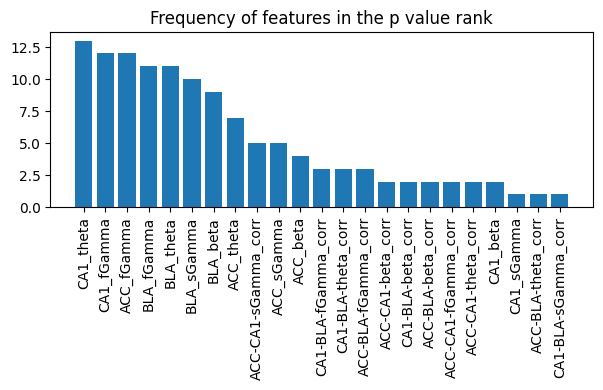

In [8]:
# count the frequency of each feature in the p_value_rank_stat, plot a histogram
feature_count = {}
for feature in p_value_rank_stat:
    if feature in feature_count:
        feature_count[feature] += 1
    else:
        feature_count[feature] = 1

# sort the feature_count dict by value
feature_count = dict(sorted(feature_count.items(), key=lambda item: item[1], reverse=True))
# plot the histogram
plt.figure(figsize=(6, 4))
plt.bar(feature_count.keys(), feature_count.values())
plt.xticks(rotation=90)
plt.title('Frequency of features in the p value rank')
plt.tight_layout()
plt.show()

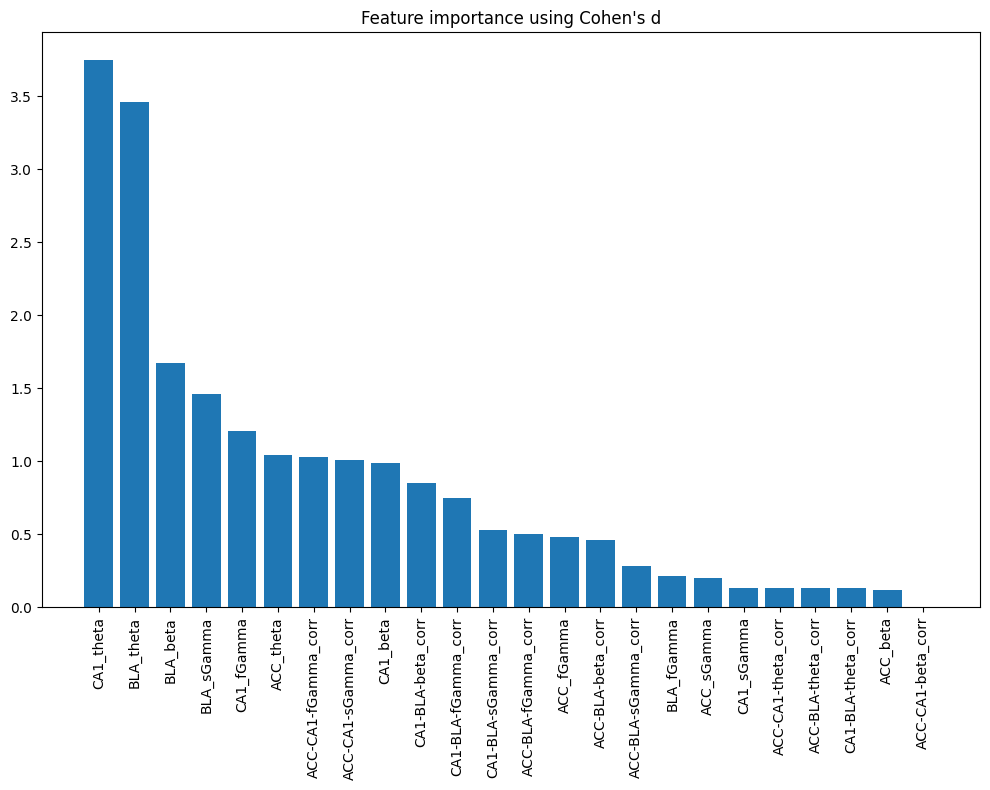

In [9]:
# print a histogram using cohend_d_stat
cohen_d_stat_sum = dict(sorted(cohen_d_stat_sum.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 8))
plt.bar(cohen_d_stat_sum.keys(), cohen_d_stat_sum.values())
plt.xticks(rotation=90)
plt.title('Feature importance using Cohen\'s d')
plt.tight_layout()
plt.show()

-------------------------------------------------------
- Max feature importance across heads for each mouse
- then, sum across mice
- plot

e:\Tools\anaconda3\envs\LFP_TRANS_LOCAL\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


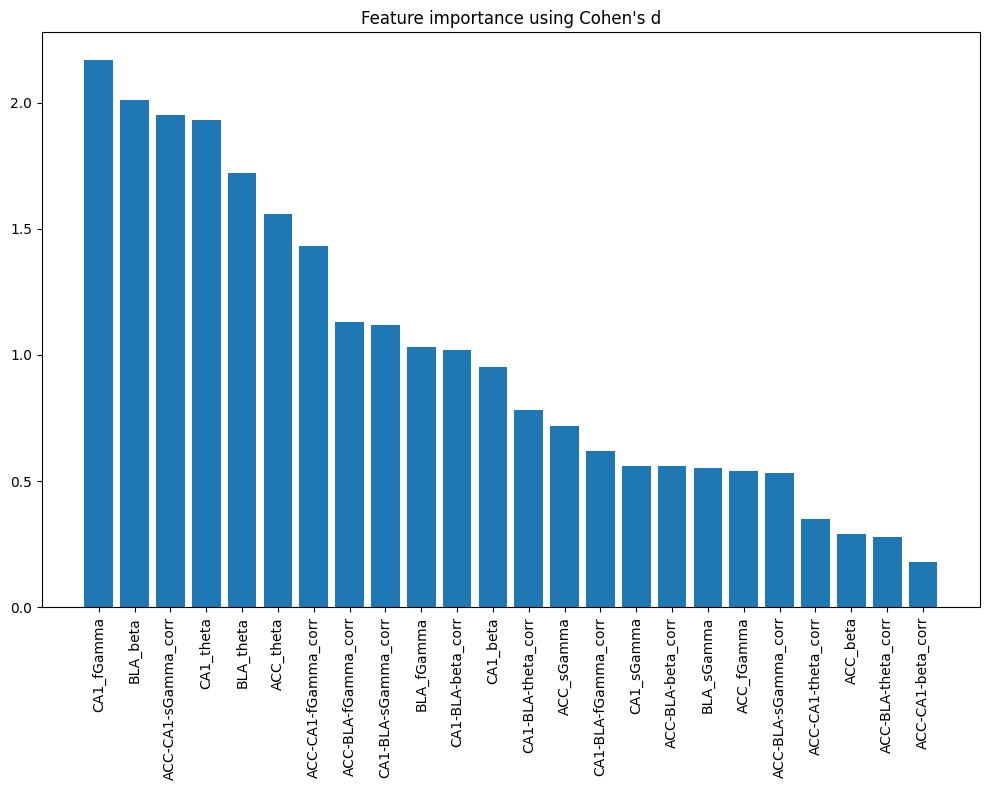

In [10]:
# feature_imp_dict with all the features as key, and initial value 0
feature_imp_dict = {feature: 0 for feature in feature_names}
feature_occur_count = {feature: 0 for feature in feature_names}

for mouse_idx in range(len(df_feature_importance_all_mice)):
    temp_df = df_feature_importance_all_mice[mouse_idx]
    # repace NaN with 0
    temp_df = temp_df.fillna(0)

    # get the max of each row, to make a new column 'max'
    temp_df['max'] = temp_df.max(axis=1)

    # add the max to the feature_imp_dict
    for feature_idx, feature_name in enumerate(feature_names):
        feature_imp_dict[feature_name] += temp_df.iloc[feature_idx]['max']

        # for feature with non-zero max, add 1 to the feature_occur_count
        if temp_df.iloc[feature_idx]['max'] != 0:
            feature_occur_count[feature_name] += 1

plt.figure(figsize=(10, 8))
# sort the feature_imp_dict by value
feature_imp_dict = dict(sorted(feature_imp_dict.items(), key=lambda item: item[1], reverse=True))
# plot the histogram
plt.bar(feature_imp_dict.keys(), feature_imp_dict.values())
plt.xticks(rotation=90)
plt.title('Feature importance using Cohen\'s d')
plt.tight_layout()
plt.show()

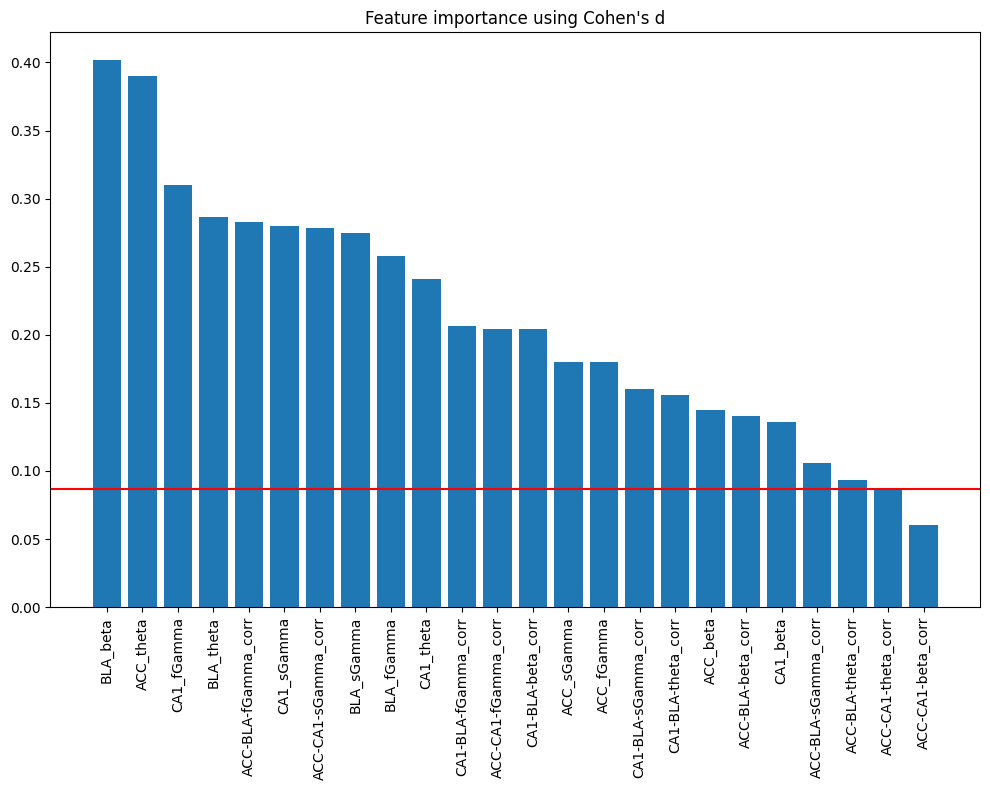

In [11]:
feature_occur_th = 9

# normalize feature_imp_dict by feature_occur_count
for feature in feature_imp_dict:
    feature_imp_dict[feature] = feature_imp_dict[feature] / feature_occur_count[feature]

# sort the feature_imp_dict by value
feature_imp_dict = dict(sorted(feature_imp_dict.items(), key=lambda item: item[1], reverse=True))

# plot the histogram
plt.figure(figsize=(10, 8))
plt.bar(feature_imp_dict.keys(), feature_imp_dict.values())
plt.xticks(rotation=90)
# horizontal line at 1/24+3*0.015
plt.axhline(y=1/24+3*0.015, color='r', linestyle='-')

plt.title('Feature importance using Cohen\'s d')
plt.tight_layout()
plt.show()

In [12]:
feature_occur_count

{'ACC_theta': 4,
 'CA1_theta': 8,
 'BLA_theta': 6,
 'ACC_beta': 2,
 'CA1_beta': 7,
 'BLA_beta': 5,
 'ACC_sGamma': 4,
 'CA1_sGamma': 2,
 'BLA_sGamma': 2,
 'ACC_fGamma': 3,
 'CA1_fGamma': 7,
 'BLA_fGamma': 4,
 'ACC-CA1-theta_corr': 4,
 'ACC-BLA-theta_corr': 3,
 'CA1-BLA-theta_corr': 5,
 'ACC-CA1-beta_corr': 3,
 'ACC-BLA-beta_corr': 4,
 'CA1-BLA-beta_corr': 5,
 'ACC-CA1-sGamma_corr': 7,
 'ACC-BLA-sGamma_corr': 5,
 'CA1-BLA-sGamma_corr': 7,
 'ACC-CA1-fGamma_corr': 7,
 'ACC-BLA-fGamma_corr': 4,
 'CA1-BLA-fGamma_corr': 3}